# Self-Organizing Sentence Processing in a Harmony Landscape

## Introduction

Starting with a featural lexical-dependency grammar, we design a Harmony Function (HF) that specifies the harmony (well-formedness) of possible combination of features and dependency links between words. The function is defined on a space of link and treelet feature variables. The gradient of HF gives the dynamics of processing, i.e., it specifies the way the link and feature values change from any initial state. Specifically, the processing dynamics can be thought of as always moving "uphill" on the harmony surface until the state reaches a local maximum of well-formedness. This approach to sentence processing is closely related to the approach outlined in a series of papers involving Pyeong Whan Cho, Paul Smolensky, Matthew Goldrick, and Richard Lewis (Cho et al., 2016, 2017, 2018). The Cho et al. approach also models sentence processing as navigation on a harmony landscape, but their harmony function and processing dynamics are somewhat more complicated. Here, we illustrate the main thrust of the harmony landscape approach and provide a simple example of sentence processing in our SOSP approach (<u>S</u>elf-<u>O</u>rganizing <u>S</u>entence <u>P</u>rocessing; Smith, Franck, & Tabor, accepted; Villata, Tabor, & Franck, submitted).

Sentence comprehension in SOSP consists of (c1) starting with the system in an initial state in which all variables (feature values and attachment link strengths) have the value 0, (c2) perceiving a word, which results in the setting of a subset of treelet features to non-zero values, (c3) gravitating under the dynamics + noise to a low velocity threshold (this generally results in nearly reaching a local harmony peak), and repeating from step (c2) until all the words in the sequence to be comprehended have been processed. Random production (useful for probing the non-contextualized distribution over parse trajectories) is accomplished by (p1) starting in the zero state, (p2) using the prior of initial word likelihoods to select a word, (p3) activating the treelet features associated with that word, (p4) gravitating under the dynamics + noise to the low velocity threshold, (p5) generating a distribution over next words from the ensemble of open lexical attachment site activations, (p6) generating a new word, and repeating from step (p3) until (p4) has produced maximal harmony or a practical limit on sentence length has been exceeded.  (The case of production of language in a discourse context will be discussed separately.)

## Grammar

The grammar is a collection of lexically anchored treelets.  Each treelet consists of a mother and a finite number of daughters, some of which may be marked "optional".  The mother and daughters are vectors of features, all of the same dimension, with the same interpretation sasigned to each dimension. For example, here is a feature vector that supports the encoding of several basic lexical types:

    Noun
    Verb
    Preposition
    Determiner
    Singular
    Plural
    Phonological or orthographic indices (these are indexical bit vectors for all the words in the language)
    
The values of these features are taken to range from -1 to +1, with -1 meaning absence, and +1 presence of the property indicated by the feature. For example, the treelets for the words "the", "dog", "cats", "near", and "sleeps" as well as a special "Root" treelet, which has no mother and licenses the matrix sentence daughter, are shown in Table 1.

Table 1.  A lexicon of treelets for a fragment of English.

    Label:          dog
    Mother:         1 0 0 0 1 0 0P # The phrase headed by "dog" is nominal and singular
    Daughter 1:     0 0 0 1 1 0 0P # Singular determiner comes first
    Daughter 2:     0 0 0 0 0 0 "dog" # The phonological/orthographic pointer to "dog"
    (Daughter 3):   0 0 1 0 0 0 0P # The noun can optionally be followed by a prepositional phrase
    
    Label:          cats
    Mother:         1 0 0 0 0 1 0P # The phrase headed by "cats" is nominal and plural
    (Daughter 1:)   0 0 0 1 0 1 0P # Plural determiner optionally comes first
    Daughter 2:     0 0 0 0 0 0 "cats" # The phonological/orthographic pointer to "cats"
    (Daughter 3):   0 0 1 0 0 0 0P # The noun can optionally be followed by a prepositional phrase
    
    Label:          near
    Mother:         0 0 1 0 0 0 0P # The phrase headed by "near" is a prepositional phrase
    Daughter 1:     0 0 0 0 0 0 "near" # The phonological/orthographic pointer to "near"
    Daughter 2:     1 0 0 0 0 0 0P # The preposition must have a Noun Phrase object

    Label:          sleeps
    Mother:         0 1 0 0 1 0 0P # The phrase headed by "sleeps" is verbal and singular
    Daughter 1:     1 0 0 0 1 0 0P # The subject comes first and must be singluar
    Daughter 2:     0 0 0 0 0 0 "sleeps" # The phonological/orthographic pointer to "sleeps"
    
    Label:          the
    Mother:         0 0 0 1 - - 0P # The phrase headed by "the" is a determiner phrase of flexible number
    Daughter 1:     0 0 0 0 0 0 "the" # The phonological/orthographic pointer to "the"
    
    Label:          Root
    Daughter 1:     0 1 0 0 0 0 0P # The daughter of root must be a verb-headed structure
     
The treelets can combine in any way that allows their features to unify, subject to the constraints that daughters can only combine with mothers, mothers can only combine with daughters, and all mothers and non-optional daughters must combine with one and only one vector. Wild card features (-) can match any value.  When vectors including wild-card features combine, the wild-card features take on the values of their partners in unification.  This system supports recursive combination:  the combination tops at out at Root and bottoms out at the phonological/orthographic forms, which have no daughters. 

Construct the grammar as a set of lexical entries (leaving off phonology/orthography for the time being):

In [5]:
import numpy as np
class LexEntry:
    def __init__(self, name, mother, dlist, head, ddir, dopt, dlabel):  
                    # name, mother vector, daughter matrix (1 per row), head daughter, optionality of daughters
        self.name = name
        self.mother = np.array(mother)
        self.dlist = np.array(dlist)
        self.head = head
        self.ddir = np.array(ddir)
        self.dopt = np.array(dopt)
        self.dlabel = dlabel
        
## Build the lexicon (daughter order information (ddir) is left empty in the manual entries, computed below)
word_dog =     LexEntry('dog',    [1, 0, 0, 0, 1, 0],   [(0, 0, 0, 1, 1, 0), 
                                                         (0, 0, 0, 0, 0, 0), 
                                                         (0, 0, 1, 0, 0, 0)], 1, [], [0, 0, 1], ['DetP',
                                                                                                 'PO',
                                                                                                 'PP'])
word_cats =     LexEntry('cats',   [1, 0, 0, 0, 0, 1],   [(0, 0, 0, 1, 0, 1), 
                                                         (0, 0, 0, 0, 0, 0), 
                                                         (0, 0, 1, 0, 0, 0)], 1, [], [1, 0, 1], ['DetP',
                                                                                                 'PO',
                                                                                                 'PP'])
word_near =    LexEntry('near',   [0, 0, 1, 0, 0, 0],   [(0, 0, 0, 0, 0, 0),
                                                         (1, 0, 0, 0, 0, 0)], 0, [], [0, 0],    ['PO',
                                                                                                 'NP(Obj)'])
word_sleeps =  LexEntry('sleeps', [0, 1, 0, 0, 1, 0],   [(1, 0, 0, 0, 1, 0),
                                                         (0, 0, 0, 0, 0, 0)], 1, [], [0, 0],    ['NP(Subj)',
                                                                                                 'PO'])
word_the =     LexEntry('the',    [0, 0, 0, 1, .5, .5], [(0, 0, 0, 0, 0, 0)], 0, [], [0],       ['PO'])
word_Root =    LexEntry('Root',   [],                   [(0, 1, 0, 0, 0, 0)], 2, [], [0],       ['VP']) # Head pos = 2
                                                                                                # implies VP daughter
                                                                                                # is leftward attaching

lexicon01 = [word_dog, word_cats, word_near, word_sleeps, word_the, word_Root]
featurecount01 = np.shape(lexicon01[0].dlist)[1]

## Add the order info based on the position of the head
for ind, word in enumerate(lexicon01):
    word.ddir = np.sign(np.array(range(len(word.dopt))) - word.head)
    
## Probe an entry
#lexicon01[3].dlabel

## Constructing the processor

Focusing first on comprehension, we consider all possible word sequences drawn from the vocabulary:

    the
    dog
    cats
    sleeps
    the dog
    the cats
    the sleeps
    etc.
    
Each word spawns a treelet which affords particular, ordered attachments. So, for a given sequence, we consider all attachments consistent with the order constraints of the treelets.  For example, in 

    the cats dog

the following links are entertained:

In [10]:
from IPython.display import IFrame
print('Figure 1.  Possible links (dashed lines) between nodes for "the cats dog". The arrows on the daughter nodes indicate the direction that daughter treelet should be found.')
IFrame("Figures/the-cats-dog.pdf", width=600, height=400)

Figure 1.  Possible links (dashed lines) between nodes for "the cats dog". The arrows on the daughter nodes indicate the direction that daughter treelet should be found.


Next, we consider link-value assignments.  Link-values generally range from around 0 to around 1, but for the purpose of defining HF, we consider only values equal to 0 or 1, and we consider only value-assignments that obey the *at-most-one-hot* constraint:  at most one fully activated link can emanate from each attachment site. (One might use a stochastic dynamical system to find most of the link combinations that obey these constraints; for the example construction below, we generated all 0/1 assignments and then eliminated those that failed to obey *at-most-one-hot*.)

To find the allowed link assignments, we first generate all links, then select allowed link assignments from among these. A link is defined as a connection between an attachment site on a treelet-instance to an attachment site on a different treelet-instance.

The indexing of the links takes the following form:

[[sentence-position$_1$ word-type$_1$ site-index$_1$] [sentence-position$_2$ word-type$_2$ site-index$_2$]]

where sentence-position counts by words, starting at 0, from the beginning of the sentence, word-type is the index of the word's class in the lexicon, and site-index gives the attachment site within the treelet (-1 = mother, 0 = first daughter, 1 = second daughter, etc.).  For example, the link from the mother of "the" to the DetP of "dog" in the diagram above is coded:

[[0 4 -1] [2 0 0]]

In [12]:
## For the string in question, find the possible links

import re
def get_words(text):
    return re.compile('\w+').findall(text)

def find_in_list(item, tlist):
    try:
        return tlist.index(item)
    except:
        return -1

## Get stringlist indices of words in currstring
def get_str_inds(currstring, stringlist):
    strinds = []
    for ind, ww in enumerate(currstring):
        currind = find_in_list(ww, stringlist)
        strinds.append(currind)
    return strinds

## Enumerate possible links (ignoring links to Phonology/Orthography)
def get_links(instring, currlex):
    currstring = get_words(instring)
    namelist = list(x.name for x in currlex)
    tlinds = get_str_inds(currstring, namelist)
    #import pdb; pdb.set_trace()
    linklist = []
    for ind1, w1 in enumerate(currstring):
        substring = list(currstring[(ind1+1):])
        ## Mother of current treelet connects to left-pointing daughters of subsequent treelets
        if len(currlex[tlinds[ind1]].mother) > 0:  # The Root node has no mother so no links should be made there
            mtlind = tlinds[ind1]
            basenode = [ind1, tlinds[ind1], -1] # Mother of current
            for ind2, w2 in enumerate(substring):
                stringpoint = ind1 + ind2 + 1
                currtlind = tlinds[stringpoint]
                for dind, currdir in enumerate(currlex[currtlind].ddir):
                    if currdir == -1:  # Daughter must be a left daughter
                        linklist.append([basenode, [stringpoint, currtlind, dind]])
        ## Daughters of current treelets point to mothers of subsequent treelets
        for dind, currdir in enumerate(currlex[mtlind].ddir): 
            basenode = [ind1, mtlind, dind]
            if currdir == 1:
                for ind2, w2 in enumerate(substring):
                    stringpoint = ind1 + ind2 + 1
                    currtlind = tlinds[stringpoint]
                    if len(currlex[currtlind].mother) > 0:   # The Root node has no mother so no links should be made there
                        linklist.append([basenode, [stringpoint, currtlind, -1]])
        
    return linklist



currstring = 'the cats dog'
wordlist = get_words(currstring)
namelist = list(x.name for x in lexicon01)
tlinds01 = get_str_inds(wordlist, namelist)

## Find all possible links in the current lexicon
linklist01 = get_links(currstring, lexicon01)
linklist01

[[[0, 4, -1], [1, 1, 0]],
 [[0, 4, -1], [2, 0, 0]],
 [[1, 1, -1], [2, 0, 0]],
 [[1, 1, 2], [2, 0, -1]]]

We now remove the links that fail to obey at-least-one-hot. To support convenient computation of Harmony values later, we construct a special link to a null node for those nodes in Figure 1 which otherwise fail to have a link under at-least-one-hot. In other words, treelets that fail to attach to other treelets can be thought of as attaching to the null treelet.

In [14]:
import pandas as pd

## Generate all bit vectors in R^{Ndim}
def hypercube(ndim):
    if (ndim == 1):
        hc = np.array([[0, 1]]).T
    else:
        subcube = hypercube(ndim-1)
        halfsize = 2**(ndim-1)
        hczeros = np.concatenate((np.array([np.zeros(halfsize)]).T, subcube), axis = 1)
        hcones = np.concatenate((np.array([np.ones(halfsize)]).T, subcube), axis = 1)
        hc = np.concatenate((hczeros, hcones), axis = 0)
    return hc

## Unique elements of any list
def unique_elements(currlist):
    uu = []
    for item in currlist:
        if item not in uu:
            uu.append(item)
    return uu

## Unique nodes in a linklist (a list of pairs of nodes)
def get_unique_nodes(linklist):   # Question: is it most efficient to do this repeatedly?
    nodelist = []
    for currlink in linklist:
        nodelist.append(currlink[0])
        nodelist.append(currlink[1])
    return unique_elements(nodelist)

## Remove link configurations that violate at-most-one-hot
def remove_trop_hot(linkacts, linklist):
    newacts = []
    for config in linkacts:
        sublinks = [linklist[ind] for ind, val in enumerate(config) if val]  # Convolve config with linklist
        subnodes = get_unique_nodes(sublinks)
        allgood = 1
        if len(subnodes) > 0:
            nodeind = 0
            while (nodeind < len(subnodes)) & allgood:
                currnode = subnodes[nodeind]
                ncount = 0
                linkind = 0
                while (linkind < len(sublinks)) & (ncount < 2):
                    currlink = sublinks[linkind]
                    if currlink[0] == currnode:
                        ncount += 1
                    if currlink[1] == currnode:
                        ncount +=1
                    linkind += 1
                if ncount >= 2:
                    allgood = 0
                nodeind += 1
        if allgood:
            newacts.append(config)
#     return newacts
    return np.array(newacts)

def convolve_lists(ilist, tlist):
    ### Select the subset of tlist for which the corresponding ilist indices are not 0
    return [tlist[ind] for ind, val in enumerate(ilist) if val]
    
def find_in_array(tval, sarray):
    return np.where((sarray == tval).all(axis=1))
    
def get_nodes(tlinds, lexicon):
    nodelist = []
    for tlindind, tlind in enumerate(tlinds):
        nodelist.append([tlindind, tlind, -1]) # The mother
        for dind, dopt  in enumerate(lexicon[tlind].dopt):
            if dind != lexicon[tlind].head:
                nodelist.append([tlindind,tlind, dind]) # The daughters (optional are included, to be ignored later as needed)
    return nodelist

nullsite = [-2, -2, -2]

## Add null attachment for nodes that are non-optional but lack an activated link
def add_unattached(linkacts, linklist, lexicon, tlinds):
    # Check each link configuration
    currnodelist = get_nodes(tlinds, lexicon)
    newacts = np.zeros((np.shape(linkacts)[0], np.shape(linkacts)[1]+len(currnodelist)))
    for cind, config in enumerate(linkacts):
        supconfig = np.zeros(len(currnodelist))
        currlinks = convolve_lists(config, linklist)
        curractivenodes = get_unique_nodes(currlinks)
        for tlindind, currtl in enumerate(tlinds):
            if len(lexicon[currtl].mother) > 0:  # If node does not have a mother, then do not link mother to nullsite
                mothernode = [tlindind, currtl, -1]
                if find_in_list(mothernode, curractivenodes) == -1:
                    nullindex = find_in_list(mothernode, currnodelist)
                    supconfig[nullindex] = 1
            for dind, dopt in enumerate(lexicon[currtl].dopt):
                if dind != lexicon[currtl].head:
                    daughternode = [tlindind, currtl, dind]
                    if find_in_list(daughternode, curractivenodes) == -1:
                        nullindex = find_in_list(daughternode, currnodelist)
                        supconfig[nullindex] = 1
                        
        #import pdb; pdb.set_trace()    
                        
        newconfig = np.concatenate([config, supconfig])
        newacts[cind, :] = newconfig   
        
    newlinks = []
    for node in currnodelist:
        newlinks.append([node, nullsite])
    linklist = linklist + newlinks
    
#     import pdb; pdb.set_trace()

    return (newacts, linklist) 

## Generate all absolute link value assignments, then remove violations
def allowed_configs(linklist, lexicon, tlinds):
    # Check each configuration to see if it satisfies at-most-one-hot
    ## Assign absolute activation patterns to the linklist
    linkacts = hypercube(np.shape(linklist)[0])
    ## Reduce to just those patterns which satisfy at-most-one-hot
    linkacts = remove_trop_hot(linkacts, linklist) 
    ## Add links for unattached 
    return add_unattached(linkacts, linklist, lexicon, tlinds)  # Note:  returns updated linkacts AND linklist

## Label the links
def make_labels(linklist, lexicon, tlinds):
    linklabels = []
    for currlink in linklist:
        
#         if currlink[0][0] > 2:
#             import pdb; pdb.set_trace()
        
        wordind0 = str(currlink[0][0]) + '.'
        phrase0 = lexicon[currlink[0][1]].name
        if currlink[0][2] == -1:
            site0 = 'mother'
        else:
            site0 = lexicon[currlink[0][1]].dlabel[currlink[0][2]]
        
        if currlink[1][0] == -2:
            phrase1 = 'Null'
            site1 = 'Null'
            wordind1 = ''
        else:
            wordind1 = str(currlink[1][0]) + '.'
            phrase1 = lexicon[currlink[1][1]].name
            if currlink[1][2] == -1:
                site1 = 'mother'
            else:
                site1 = lexicon[currlink[1][1]].dlabel[currlink[1][2]]
        linklabels.append(wordind0 + phrase0 + '(' + site0 + ')' + '-' + wordind1 + phrase1 + '(' + site1 + ')')
    return linklabels 

## Run, format, and print
actslinks = allowed_configs(linklist01, lexicon01, tlinds01)
allowed01 = actslinks[0]
auglinklist01 = actslinks[1]
auglinklabels01 = make_labels(auglinklist01, lexicon01, tlinds01)
nodelist01 = get_unique_nodes(auglinklist01)  # This is not needed here, but it's useful to refer to

#df = pd.DataFrame(allowed01[:, 0:4], index=None, columns = auglinklabels01[0:4])
df = pd.DataFrame(allowed01, index=None, columns = auglinklabels01)

print('Table 2.  Allowed link assignments for "the cats dog".  The last 7 columns show links to')
print('          the Null Object, which are not depicted in Figure 1.')
df

Table 2.  Allowed link assignments for "the cats dog".  The last 7 columns show links to
          the Null Object, which are not depicted in Figure 1.


,0.the(mother)-1.cats(DetP),0.the(mother)-2.dog(DetP),1.cats(mother)-2.dog(DetP),1.cats(PP)-2.dog(mother),0.the(mother)-Null(Null),1.cats(mother)-Null(Null),1.cats(DetP)-Null(Null),1.cats(PP)-Null(Null),2.dog(mother)-Null(Null),2.dog(DetP)-Null(Null),2.dog(PP)-Null(Null)
0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
1,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0
2,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0
3,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0
4,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0
5,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0
6,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0
7,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0
8,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0
9,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [15]:
nodelist01

[[0, 4, -1],
 [1, 1, 0],
 [2, 0, 0],
 [1, 1, -1],
 [1, 1, 2],
 [2, 0, -1],
 [-2, -2, -2],
 [2, 0, 2]]

The string, "the cats dog", is not, under the current grammar, a grammatical sentence or even a grammatical initial substring (although it is a grammatical initial substring in English as a whole because "dog" has a rare interpretation as a transitive verb).   In the current scheme, the "allowed link assignments" means those for which the order constraints of the words are obeyed and the at-most-one-hot constraint is obeyed, including but not limited to those that make the string grammatical. 

Each entry in Table 2 gives rise to an upward deflection of $HF$. To accomplish this, we place a radial basis function (RBF) with its center at the state corresponding to the vector of link values. The next step is to determine the magnitude of the upward deflection. For this, we define the local harmony $h_i$ of an absolute link configuration $i$ as:

$$h_i = \prod_{k \in Links} \left(act(k) \frac{|\sum_{j \in Features} \rho(d_{kj}) \cdot \rho(m_{kj})|}{|Features|} \right)$$

$$\rho(x) = 2x - 1$$

where $act(k)$ is the activation of Link $k$ (either 0 or 1), $d_j$ is the $j$'th feature value of the daughter node of the link, $m_j$ is the $j$'th feature value of the mother node of the link, $|Features|$ is the number of features in the feature vector, $\lambda$ is a parameter that specifies the penalty associated with an unattached open site. The feature values used in the evaluation of $h_i$ are those specified in the lexicon of treelets (Table 1), assuming that feature convergence occurs on all links involving wildcards. The local harmony is high if all activated links are associated with good feature matches. 

The following code produces Table 3, which gives the local harmony values associated with each of the link activation patterns in Table 2.

In [16]:
def rho(vec):
    return 2*vec - 1

from copy import deepcopy

nullmult = 0.01

def get_local_harmonies(allowed, auglinklist, currlex):
    
    ## Debugging
    dbline = -1
    
    #print('Starting local harmony comp.')

    hlist = []
    for cind, config in enumerate(allowed):
        hl = 1  # Local harmony
        
#         if cind == dbline:
#             print('Made it inside cind loop')
#             import pdb; pdb.set_trace()
            
        for lind, currswitch in enumerate(config):
            
#             if cind == dbline:
#                 print('Made it inside lind loop')
#                 import pdb; pdb.set_trace()
        
            if currswitch == 1:
                nulllink = 0
                currlink = auglinklist[lind]
                
#                 if cind == dbline:
#                     print('Looking at currlink')
#                     import pdb; pdb.set_trace()
            
                if currlink[1][0] == -2:  # The link is to a null node
                    if currlink[0][2] == -1:  # It's a mother that's connecting to the null node
                        currmult = nullmult
                    else:  # It is a daughter that's connecting to the null node
                        if currlex[currlink[0][1]].dopt[currlink[0][2]]:  # The daughter is optional
                            currmult = 1
                        else:
                            currmult = nullmult
                else:
                    
#                     if cind == dbline:
#                         print('Made it to considering non-null links')
#                         import pdb; pdb.set_trace()
            
                    if currlink[0][2] == -1:  # The left end of the link is a mother
                        leftfeat = deepcopy(currlex[currlink[0][1]].mother)
                
                        if cind == dbline:
                            print('Leftfeat: ' + currlex[currlink[0][1]].name + '-' 
                                + 'mother')

                    else:   # The left end of the link is a daughter
                        leftfeat = deepcopy(currlex[currlink[0][1]].dlist[currlink[0][2]])
                
                        if cind == dbline:
                            print('Leftfeat: ' + currlex[currlink[0][1]].name + '-' 
                                + currlex[currlink[0][1]].dlabel[currlink[0][2]])
                
                    if currlink[1][2] == -1:  # The right end of the link is a mother
                        rightfeat = deepcopy(currlex[currlink[1][1]].mother)
                
                        if cind == dbline:
                            print('Rightfeat: ' + currlex[currlink[1][1]].name + '-' 
                                + 'mother')
                    
                    else:   # The right end of the link is a daughter
                        rightfeat = deepcopy(currlex[currlink[1][1]].dlist[currlink[1][2]])
                
                        if cind == dbline:
                            print('Rightfeat: ' + currlex[currlink[1][1]].name + '-' 
                                + currlex[currlink[1][1]].dlabel[currlink[1][2]])
                      
                    #if cind == dbline:
#                         print('Initial:')
#                         print('leftfeat = ', leftfeat)
#                         print('rightfeat = ', rightfeat)

                    # Handle the wildcard features
                    for find, currleft in enumerate(leftfeat):
                        if currleft == 0.5:
                            leftfeat[find] = rightfeat[find]
                        if rightfeat[find] == 0.5:
                            rightfeat[find] = leftfeat[find]
                            
#                     if cind == dbline:
#                         print('Revised:')
#                         print('leftfeat = ', leftfeat)
#                         print('rightfeat = ', rightfeat)            
                              
                    currmult = np.absolute(np.inner(rho(leftfeat), rho(rightfeat)))/len(leftfeat)
    
                hl *= currmult
  
                ## Debugging

                if cind == dbline:
                    print(hl)
                    import pdb; pdb.set_trace()
                
        hlist.append(hl)
    
    return hlist
    
hlist01 = get_local_harmonies(allowed01, auglinklist01, lexicon01)
df['Local-Harmonies'] = np.round(hlist01, 6)
print('Table 3.  Harmonies associated with the link configurations in Table 2.')
# df  ## Print whole table
df.iloc[:, [0, 1, 2, 3, 11]]   ## Print without the links to the null node

Table 3.  Harmonies associated with the link configurations in Table 2.


,0.the(mother)-1.cats(DetP),0.the(mother)-2.dog(DetP),1.cats(mother)-2.dog(DetP),1.cats(PP)-2.dog(mother),Local-Harmonies
0,0.0,0.0,0.0,0.0,0.000000
1,0.0,0.0,0.0,1.0,0.000000
2,0.0,0.0,1.0,0.0,0.000033
3,0.0,0.0,1.0,1.0,0.000000
4,0.0,1.0,0.0,0.0,0.000100
5,0.0,1.0,0.0,1.0,0.000000
6,1.0,0.0,0.0,0.0,0.000001
7,1.0,0.0,0.0,1.0,0.000000
8,1.0,0.0,1.0,0.0,0.003333
9,1.0,0.0,1.0,1.0,0.000000


In [18]:
auglinklist01

[[[0, 4, -1], [1, 1, 0]],
 [[0, 4, -1], [2, 0, 0]],
 [[1, 1, -1], [2, 0, 0]],
 [[1, 1, 2], [2, 0, -1]],
 [[0, 4, -1], [-2, -2, -2]],
 [[1, 1, -1], [-2, -2, -2]],
 [[1, 1, 0], [-2, -2, -2]],
 [[1, 1, 2], [-2, -2, -2]],
 [[2, 0, -1], [-2, -2, -2]],
 [[2, 0, 0], [-2, -2, -2]],
 [[2, 0, 2], [-2, -2, -2]]]

The next step is to build the global harmony function, HF, out of the local harmony values. In Table 3, we consider all the local harmony values associated with one word string, "the cats dog". To build the full harmony function, we must include a term for every local harmony value associated with every possible order of all the words in the vocabulary. That is, we assume different treelets for each word in each position in the sentence, and find the harmonies of all strings with the location-specific treelets. In practice, for modeling comprehension, we will often leave out terms associated with words that do not occur in the sentence. This simplification assumes no confusion of phonological forms and no hallucination or forgetting of words, assumptions which are clearly inaccurate, but which often do not play an important role in particular phenomena of interest. We also sometimes even consider only one order of words (but typically including all initial substrings of that order). This simplification assumes no word-order confusions, again, not a realistic assumption but, nevertheless, one that sometimes does not plausibly affect a particular case of interest.

The global harmony function, $HF(\mathbf{s})$, is constructed by placing an RBF, $\phi_i$ at each local harmony locus, $h_i$:

$$HF(\mathbf{s}) = \sum_{i \in Configurations} h_i\ \phi_i(\mathbf{s})$$

where 

$$\phi_i(\mathbf{s}) = \exp{\left(-\frac{\Vert\mathbf{s} - \mathbf{c}_i\Vert^2_2}{\gamma}\right)}$$

Here, $\mathbf{s}$ is the system state, i.e., the vector of activations of all the links and features. Each of these values ranges, in principle, over $(-\infty, \infty)$, but because of the design of the harmony function, the values will stay close the interval $[0, 1]$.  $\mathbf{c}_i$ is the center of the $i$th RBF. $\gamma$ is a free parameter which specifies the widths of the RBFs, and thus determines how strongly the system prefers to achieve optimal parses (greater $\gamma$ means stronger preference for maximal harmony). $\Vert\cdot\Vert^2_2$ is Euclidean distance or the squared L2 norm.

The dynamics of the system are given by the gradient of harmony + noise:

$$\dot{\mathbf{s}} = \frac{d}{dt}\mathbf{s} = \nabla HF = -\frac{2}{\gamma}\sum_{i} h_i\ (\mathbf{s} - \mathbf{c}_i) \cdot \phi_i(\mathbf{s})\ + \ \alpha\cdot\eta$$

where $\dot{\mathbf{s}}$ denotes the change in the state variable with respect to time and $\eta$ is normally distributed random noise. The magnitude, $\alpha$, of the noise is a free parameter.

## Building and running a simulation:  encoding interference example

Barker et al. (2001) found that semantic similarity enhanced attraction:

    The canoe near the sailboats ...   (MORE plural)
    The canoe near the cabins ...      (LESS plural)
    
This can be understood as an encoding- as opposed to a retrieval-interference effect because (as we far as we know) the verbs do not select for the semantic features (e.g. + Building, + Boat, etc) 

Villata et al. and Smith et al find, roughly, semantic that similarity in these kinds of sentences also slows down reading time at the verb and causes worse performance on comprehension questions which check to see whether the participants have correctly assigned the semantic roles.

We first make a lexicon suitable to this case:

    Features:     Noun Verb Prep Boat Building Sg Pl  

                

In [6]:
## Build the lexicon 
sim1_canoe =     LexEntry('canoe',  [1, 0, 0, 1, 0, 1, 0],    [(0, 0, 0, 0, 0, 0, 0), 
                                                               (0, 0, 1, 0, 0, 0, 0)], 0, [], [0, 1], ['PO',
                                                                                                       'PP'])
sim1_canoes =    LexEntry('canoes', [1, 0, 0, 1, 0, 0, 1],    [(0, 0, 0, 0, 0, 0, 0), 
                                                               (0, 0, 1, 0, 0, 0, 0)], 0, [], [0, 1], ['PO',
                                                                                                       'PP'])
sim1_cabin =     LexEntry('cabin',  [1, 0, 0, 0, 1, 1, 0],    [(0, 0, 0, 0, 0, 0, 0), 
                                                               (0, 0, 1, 0, 0, 0, 0)], 0, [], [0, 1], ['PO',
                                                                                                       'PP'])
sim1_cabins =    LexEntry('cabins', [1, 0, 0, 0, 1, 0, 1],    [(0, 0, 0, 0, 0, 0, 0), 
                                                               (0, 0, 1, 0, 0, 0, 0)], 0, [], [0, 1], ['PO',
                                                                                                       'PP'])
sim1_sinks =     LexEntry('sinks',  [0, 1, 0, 0, 0, 1, 0],    [(1, 0, 0, 0.5, 0.5, 1, 0),
                                                               (0, 0, 0, 0,   0,   0, 0)], 1, [], [0, 0], ['NP(Subj)',
                                                                                                           'PO'])
sim1_sink =      LexEntry('sink',   [0, 1, 0, 0, 0, 0, 1],    [(1, 0, 0, 0.5, 0.5, 0, 1),
                                                               (0, 0, 0, 0,   0,   0, 0)], 1, [], [0, 0], ['NP(Subj)',
                                                                                                           'PO'])
sim1_near =      LexEntry('near',   [0, 0, 1, 0, 0, 0, 0],    [(0, 0, 0, 0,   0,   0,   0),
                                                               (1, 0, 0, 0.5, 0.5, 0.5, 0.5)], 0, [], [0, 0], ['PO',
                                                                                                            'NP(Obj)'])
sim1_Root =      LexEntry('Root',   [],                       [(0, 1, 0, 0, 0, 0.5, 0.5)], 2, [], [0],     ['VP'])  
                                                                                                # Head pos = 2
                                                                                                # implies VP daughter
                                                                                                # is leftward attaching

sim1lex = [sim1_canoe, sim1_canoes, sim1_cabin, sim1_cabins, sim1_sinks, sim1_sink, sim1_near, sim1_Root]
featurecountsim1 = np.shape(sim1lex[0].dlist)[1]

## Add the order info based on the position of the head
for ind, word in enumerate(sim1lex):
    word.ddir = np.sign(np.array(range(len(word.dopt))) - word.head)

The next step in a full construction would be to build all strings of all finite lengths from the vocabulary ($\Sigma^*$, where $\Sigma$ is the set of vocabulary items).  Since this is impractical, we select a subset that are arguably all the ones relevant to the cases of current interest.

In [18]:
sim1strings = [ # Grammatical:
                'canoe near canoe sinks Root', 'canoe near canoes sinks Root', 'canoes near canoe sink Root',
                'canoes near canoes sink Root',
                'canoe near cabin sinks Root', 'canoe near cabins sinks Root', 'canoes near cabin sink Root',
                'canoes near cabins sink Root',
                # Ungrammatical:
                'canoe near canoe sink Root', 'canoe near canoes sink Root', 'canoes near canoe sinks Root',
                'canoes near canoes sinks Root', 
                'canoe near cabin sink Root', 'canoe near cabins sink Root', 'canoes near cabin sinks Root',
                'canoes near cabins sinks Root']

Then we identify local Harmony maxima for each string, forming htable, a table that can be used to calculate harmonies of states.

In [16]:
sim1strings

['canoe near canoe sinks Root',
 'canoe near canoes sinks Root',
 'canoes near canoe sink Root',
 'canoes near canoes sink Root',
 'canoe near cabin sinks Root',
 'canoe near cabins sinks Root',
 'canoes near cabin sink Root',
 'canoes near cabins sink Root']

In [25]:
import pdb

nullmult = 0.5;  # This is a key parameter:  the harmony multiplier associated with each mandatory 
                 # attachment site that fails to attach

# Find all the links, nodes, and local Harmony maxima for each string
complistsim1 = []
nlocalh = 0
for currstring in sim1strings:
    wordlist = get_words(currstring)
    namelist = list(x.name for x in sim1lex)
    currtlinds = get_str_inds(wordlist, namelist)
    currlinklist = get_links(currstring, sim1lex)
    actslinks = allowed_configs(currlinklist, sim1lex, currtlinds)
    currallowed = actslinks[0]
    currauglinklist = actslinks[1]
    currauglinklabels = make_labels(currauglinklist, sim1lex, currtlinds)
    # Separate nullsite links out
    seconds = [x[1] for x in currauglinklist]
    nullindex = find_in_list(nullsite, seconds)
    currlinksmain = currauglinklist[0:nullindex]
    currlinksnull = currauglinklist[nullindex:(len(currauglinklist)+1)]
    currlabelsmain = currauglinklabels[0:nullindex]
    currlabelsnull = currauglinklabels[nullindex:(len(currauglinklist)+1)]
    
    currnodelist = get_unique_nodes(currauglinklist)
    currhlist = get_local_harmonies(currallowed, currauglinklist, sim1lex)
    
    complistsim1.append([currallowed, currhlist, currlinksmain, currlabelsmain, currlinksnull, currlabelsnull, currnodelist])
    nlocalh += len(currhlist)
    
# Compile the links and nodes across strings to make the state vector

linklistsim1 = []
linklabelssim1 = []
nodelistsim1 = []
nodelabelssim1 = []

# Compile main links
for sind, currpac in enumerate(complistsim1):
    for lind, currlink in enumerate(currpac[2]):
        if currlink not in linklistsim1:
            linklistsim1.append(currlink)
            linklabelssim1.append(currpac[3][lind])
nmainlinks = len(linklistsim1)
# Add in the null links
for sind, currpac in enumerate(complistsim1):
    for lind, currlink in enumerate(currpac[4]):
        if currlink not in linklistsim1:
            linklistsim1.append(currlink)
            linklabelssim1.append(currpac[5][lind])
# Add in the nodes
for sind, currpac in enumerate(complistsim1):
    for nind, currnode in enumerate(currpac[6]):
        if currnode not in nodelistsim1:
            nodelistsim1.append(currnode)
            if currnode[2] == -1:
                sublabel = 'mother'
            else:
                sublabel = sim1lex[currnode[1]].dlabel[currnode[2]]
            currnodelabel = str(currnode[0]) + '.' + sim1lex[currnode[1]].name + '(' + sublabel + ')'
            nodelabelssim1.append(currnodelabel)
nullind = find_in_list(nullsite, nodelistsim1)
nulllabel = nodelabelssim1[nullind]
nodelistsim1.remove(nullsite)
nodelabelssim1.remove(nulllabel)



## Make labels for the individual features on the nodes of the treelets
lastlinkind = len(linklistsim1)-1
nstatevars = lastlinkind + 1 + len(nodelistsim1)*featurecountsim1
htable = np.zeros((nlocalh, nstatevars))
hvals = np.zeros(nlocalh)
hlabels = []
for llabel in linklabelssim1:
    hlabels.append(llabel)
for nlabel in nodelabelssim1:
    for rind in range(featurecountsim1):
         hlabels.append(nlabel)
hlabels_arr = np.array(hlabels)
                                  
# For each local Harmony maximum, make an entry in htable that specifies its state and the local Harmony elevation
currlh = -1
for pind, currpac in enumerate(complistsim1):  # Go through the strings
    for cind, config in enumerate(currpac[0]):  # Go through the maxima for each string
        currlh += 1
        for lind, lact in enumerate(config):  # Specify activated links
            if lact:
                if lind < len(currpac[2]):  
                    currlink = currpac[2][lind]  # First draw from the main link list
                else:
                    currlink = currpac[4][lind - len(currpac[2])] # Then draw from the null link list
                    
                # Activate the link
                htable[currlh, find_in_list(currlink, linklistsim1)] = 1
                       
                # Activate the first attachment site
                firstnode = currlink[0]
                firstind = find_in_list(firstnode, nodelistsim1)
                if firstnode[2] == -1:
                       fvals = sim1lex[firstnode[1]].mother
                else:
                       fvals = sim1lex[firstnode[1]].dlist[firstnode[2]]
                bankstart = lastlinkind + (firstind-1)*featurecountsim1 + 1
                bankend = lastlinkind + (firstind-1)*featurecountsim1 + featurecountsim1 + 1
                htable[currlh, bankstart:bankend] = fvals

                # Activate the second attachment site
                secondnode = currlink[1]
                if secondnode[0] != -2: # No need to activate features for the null site
                    secondind = find_in_list(secondnode, nodelistsim1)
                    if secondnode[2] == -1:
                        fvals = sim1lex[secondnode[1]].mother
                    else:
                        fvals = sim1lex[secondnode[1]].dlist[secondnode[2]]
                    bankstart = lastlinkind + (secondind-1)*featurecountsim1 + 1
                    bankend = lastlinkind + (secondind-1)*featurecountsim1 + featurecountsim1 + 1
                    htable[currlh, bankstart:bankend] = fvals
        hvals[currlh] = currpac[1][cind] 
        
#         if (pind == 5) & (cind == 59):
#             print(hvals[currlh])
#             pdb.set_trace()
        
#         if (currlh == 12) or (currlh == 828):
#             print(currlh)
#             pdb.set_trace()
        
#import pdb; pdb.set_trace()

# Reduce the harmony table by removing very low harmony peaks
hmin = 0.2
#hmin = 0.12
#hmin = 1   # Try including only grammatical structures

rhtable = []
rhvals = []
rtohind = []
for hind, currhval in enumerate(hvals):
    if currhval >= hmin:
        rhtable.append(htable[hind, :])
        rhvals.append(currhval)
        rtohind.append(hind)
rhtable = np.array(rhtable)
rhvals = np.array(rhvals)
rtohind = np.array(rtohind)

# Kludge high harmony for 41
#rhvals[41] = 2.0
#rhvals[41] = 0.5

rhmain = rhtable[:, 0:nmainlinks] # Store this useful subpart for reference later


dfallh = pd.DataFrame(rhtable, index=None, columns = hlabels)
dfallh['Local-Harmonies'] = rhvals
# print('Table 4.  Combined harmony table.')
# dfallh  ## Print whole table

#dfallh.iloc[0:4, np.concatenate(np.arange(0, 16), [np.shape(dfallh)[1] - 1])]  # Print a small piece
#dfallh.iloc[:, [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, np.shape(dfallh)[1] - 1]]
print('Number of main links:  ', nmainlinks)
print('Table 4.  A piece of the combined harmony table.')
#dfallh.iloc[:, [0, 1, 2, 3, 4, 5, 6, 7, np.shape(dfallh)[1] - 1]]

Number of main links:   51
Table 4.  A piece of the combined harmony table.


In [26]:
np.shape(rhtable)

(80, 211)

In [78]:
## Some probing

print(sim1strings[5])


currpac5 = complistsim1[5]
nmainlinks5 = len(currpac5[3])

mainlabels5 = currpac5[3]
mainlabels5

mainlabels5 = np.array(mainlabels5)

targmain5 = np.zeros(nmainlinks5)
tvec = [2, 9, 12]
targmain5[np.array(tvec)] = 1

configs = currpac5[0]
configs = configs[:, 0:nmainlinks5]

target = targmain5
#target = np.array(configs[3])

matchlist = []
for hind, config in enumerate(configs):
    if (config == target).all():
        matchlist.append(hind)
matchlist

#configs[59]

#mainlabels5[tvec]

hlist5 = currpac5[1]
hlist5[59]



dog near dogs sleep Root


0.25

In [12]:
## Some probing

#print(rtohind[1])  # Result:  12
#print(rtohind[45])  # Result:  828
print('activated at peak 12:  ', np.where(htable[12, :] == 1)[0])
print('activated at peak 828:  ', np.where(htable[828, :] == 1)[0])  # complistsim1[6] item 12, I think

print(hlabels_arr[np.array([7, 12])])
nmainlinks, lastlinkind

# for pind, currpac in enumerate(complistsim1):  # Go through the strings
#     print(pind, np.shape(currpac[0]))

currpac0 = complistsim1[0]

print('main links shape:  ', np.shape(currpac0[2]))
print('null links shape:  ', np.shape(currpac0[4]))

print('config of peak 12:  ', currpac0[0][12])
print('labels for main links of 12:  ', currpac0[3])
print('labels for null links of 12:  ', currpac0[5])

currpac6 = complistsim1[6]

print('main links shape:  ', np.shape(currpac6[2]))
print('null links shape:  ', np.shape(currpac6[4]))

print('config of peak 12:  ', currpac6[0][12])
print('labels for main links of 12:  ', currpac6[3])
print('labels for null links of 12:  ', currpac6[5])


activated at peak 12:   [ 7 12 35 36 37 40 42 46 49 51 54 57 63 68 71 74 77 79 81 88]
activated at peak 828:   [  7  12  37  40  42  47  48  51  54  57  68  71  74  77  79  81  88 106
 110 118]
['1.near(NP(Obj))-2.dog(mother)' '3.sleeps(mother)-4.Root(VP)']
main links shape:   (13, 2, 3)
null links shape:   (10, 2, 3)
config of peak 12:   [ 0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  1.  1.  1.  1.  0.  0.
  1.  0.  1.  0.  0.]
labels for main links of 12:   ['0.dog(mother)-3.sleeps(NP(Subj))', '0.dog(mother)-4.Root(VP)', '0.dog(PP)-1.near(mother)', '0.dog(PP)-2.dog(mother)', '0.dog(PP)-3.sleeps(mother)', '1.near(mother)-3.sleeps(NP(Subj))', '1.near(mother)-4.Root(VP)', '1.near(NP(Obj))-2.dog(mother)', '1.near(NP(Obj))-3.sleeps(mother)', '2.dog(mother)-3.sleeps(NP(Subj))', '2.dog(mother)-4.Root(VP)', '2.dog(PP)-3.sleeps(mother)', '3.sleeps(mother)-4.Root(VP)']
labels for null links of 12:   ['0.dog(mother)-Null(Null)', '0.dog(PP)-Null(Null)', '1.near(mother)-Null(Null)', '1.near(NP

(52, 131) 35 50


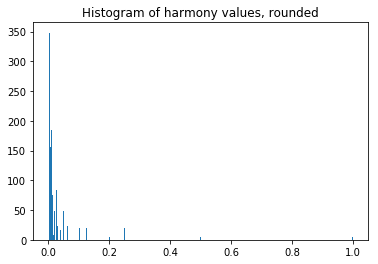

median hval =  0.008


52

In [12]:
# Histogram of harmonies

import matplotlib.pyplot as pl

print(np.shape(rhtable), nmainlinks, lastlinkind)
# print(np.where(hlabels_arr == '0.dog(mother)')[0]) 
# print(np.where(hlabels_arr == '4.Root(VP)')[0]) 
# hlabels[51:57]
#print(hlabels[0:nmainlinks])

pl.hist(np.around(hvals, 4), bins='auto')
pl.title('Histogram of harmony values, rounded')
pl.show()

print('median hval = ', np.median(hvals))
len(np.where(hvals >= 0.12)[0])


As an illustration, run the network once with the input "dog near dogs"

In [75]:
import pdb

# maxsteps = 200    # Maximum number of steps per settling episode
# gamma = 1        # Width parameter for Gaussians
# #gamma = 0.5
# #gamma = 0.25
# #gamma = 1
# #tol = 0.1;         # Distance from goal that counts as having successfully reached it
# #tol = 0.2;
# tol = 1
# #tol = 3
# #tol = 0.5
# #noisemag = 0.05;   # Magnitude of gaussian random noise applied at very activation update (Euler integration)
# #noisemag = 0.0001;
# #noisemag = 0.005; # Works with gamma = 1
# noisemag = 0.05; # 
# #noisemag = 0.1; # Shows some variety (tol = 3, gamma = 0.25) including with 'dog near dogs'
# #nflips = 5;  # 
# stepcontract = 5;

maxsteps = 200    # Maximum number of steps per settling episode
gamma = 2        # Width parameter for Gaussians
tol = 2
noisemag = 0.06;
stepcontract = 5;

def getda(aa, htable, hvals, gamma):

    da = np.zeros(len(aa))
    
    currmin = 4*len(aa)
    for hind, currh in enumerate(hvals):
        currdiffvec = aa - htable[hind, :]
        currmag = np.linalg.norm(currdiffvec)
        phi = np.exp(-currmag**2/gamma)
        da = da + hvals[hind] * phi * currdiffvec
        
        #if hind == 41:
        #   pdb.set_trace()
        
        if currmag < currmin:
            currmin = currmag
        
    da = -2 * da / gamma
    
    return (da, currmin)

def gravitate(aa0, rhtable, rhvals, gamma, maxsteps, stepcontract):
    
    # The novelty of this version as that noise works by flipping bits

    aa = deepcopy(aa0)
    stable = 0
    scount = 0
    ehist = []
    while (not stable) & (scount < maxsteps):
        scount += 1
        dapac = getda(aa, rhtable, rhvals, gamma)

        da = dapac[0]

        stepsize = 1 / (stepcontract*np.linalg.norm(da))
        aa += stepsize*da + noisemag*np.random.normal(0, 1, ndim)
        #aa += stepsize*da
        #flipcan = np.random.randint(0, ndim-1, nflips)
        
#         for dind, cind in enumerate(flipcan):
#             if np.random.randint(0, 2) == 1:
#                 aa[dind] = 1 - aa[dind]

        #stable = np.linalg.norm(da) < tol 
        ehist.append(dapac[1])
        stable = dapac[1] < tol
        
    return (aa, ehist)

def set_initial_state(currstring, currlex, ndim, grading):

    aa0 = np.zeros(ndim)
    
    wordstring = get_words(currstring)
    namelist = list(x.name for x in sim1lex)
    tlindssim1 = get_str_inds(wordstring, namelist)
    if len(grading) == 0:
        grading = np.ones(len(wordstring))
    for wind, currword in enumerate(wordstring):
        currlexind = tlindssim1[wind]
        if currlexind > -1:   # If there is no word in the current position, then make no change based on the position
            curritem = sim1lex[currlexind]
            if len(curritem.mother) > 0:
                currlabel = str(wind) + '.' + currword + '(' + 'mother' + ')'
                currinds = np.where(hlabels_arr == currlabel)[0]
                aa0[currinds] = grading[wind]*curritem.mother
            for dcount, optval in enumerate(curritem.dopt):
                if ~optval & (not dcount == curritem.head):
                    currlabel = str(wind) + '.' + currword + '(' + curritem.dlabel[dcount] + ')'
                    currinds = np.where(hlabels_arr == currlabel)[0]
                    aa0[currinds] = grading[wind]*curritem.dlist[dcount]
                    if len(currinds) == 0:
                        print('Problem:  label not found: ', currlabel)
                        pdb.set_trace()
    return aa0

def get_choice(aa, htable):

    dvec = []
    for fvec in htable:
        dvec.append(np.linalg.norm(aa - fvec))
    mindist = np.min(dvec)
    currchoice = np.where(dvec == mindist)[0]
    currchoice = currchoice[0]  ###  Note:   I don't know why this is necessary!! (Glosses over possib. of mult. mins)

    return currchoice, mindist

### Main

## In this version, set all the feature vectors for the words at once (rather than presenting them sequentially)
## Set each feature vector to 

ndim = np.shape(htable)[1]

currstring = 'canoe near cabin'; grading = np.array([])

# grading = []
aa0 = set_initial_state(currstring, sim1lex, ndim, grading)  # Set grading to empty for no grading

# Kludge initial link activations
#aa0[0:lastlinkind] = 0.01*rhtable[41, 0:lastlinkind]

(aa, ehist) = gravitate(aa0, rhtable, rhvals, gamma, maxsteps, stepcontract) 
    
aaround = np.around(aa, 2)
aaroundmain = aaround[0:nmainlinks]

(currchoice, mindist) = get_choice(aa, rhtable)
    
print('selected harmony peak:  ', currchoice)
print('harmony of peak:  ', rhvals[currchoice])
print('distance from peak:  ', mindist)
print('number of steps:  ', len(ehist))

selected harmony peak:   6
harmony of peak:   1.0
distance from peak:   1.99276563116
number of steps:   56


In [343]:
lastlinkind

50

In [15]:
keypeak = 35
print("keypeak = ", keypeak)
print("hval = ", rhvals[keypeak])
keyind = np.where(rhmain[keypeak, :] == 1)[0]
print("keyind = ", keyind)
print(hlabels_arr[keyind])

keypeak = 17
print("keypeak = ", keypeak)
print("hval = ", rhvals[keypeak])
keyind = np.where(rhmain[keypeak, :] == 1)[0]
print("keyind = ", keyind)
print(hlabels_arr[keyind])

keypeak =  35
hval =  1.0
keyind =  [14 18 20 27]
['1.near(NP(Obj))-2.dogs(mother)' '0.dogs(mother)-3.sleep(NP(Subj))'
 '0.dogs(PP)-1.near(mother)' '3.sleep(mother)-4.Root(VP)']
keypeak =  17
hval =  1.0
keyind =  [ 0  2 12 14]
['0.dog(mother)-3.sleeps(NP(Subj))' '0.dog(PP)-1.near(mother)'
 '3.sleeps(mother)-4.Root(VP)' '1.near(NP(Obj))-2.dogs(mother)']


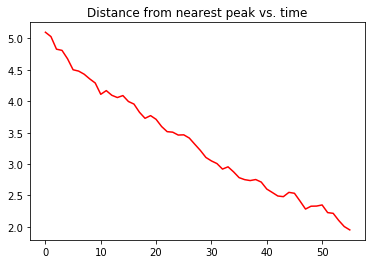

In [76]:
import matplotlib.pyplot as pl
pl.plot(range(len(ehist)), ehist, 'r')
pl.title('Distance from nearest peak vs. time')
pl.show()

In [16]:
print(hlabels_arr[0:nmainlinks])

['0.dog(mother)-3.sleeps(NP(Subj))' '0.dog(mother)-4.Root(VP)'
 '0.dog(PP)-1.near(mother)' '0.dog(PP)-2.dog(mother)'
 '0.dog(PP)-3.sleeps(mother)' '1.near(mother)-3.sleeps(NP(Subj))'
 '1.near(mother)-4.Root(VP)' '1.near(NP(Obj))-2.dog(mother)'
 '1.near(NP(Obj))-3.sleeps(mother)' '2.dog(mother)-3.sleeps(NP(Subj))'
 '2.dog(mother)-4.Root(VP)' '2.dog(PP)-3.sleeps(mother)'
 '3.sleeps(mother)-4.Root(VP)' '0.dog(PP)-2.dogs(mother)'
 '1.near(NP(Obj))-2.dogs(mother)' '2.dogs(mother)-3.sleeps(NP(Subj))'
 '2.dogs(mother)-4.Root(VP)' '2.dogs(PP)-3.sleeps(mother)'
 '0.dogs(mother)-3.sleep(NP(Subj))' '0.dogs(mother)-4.Root(VP)'
 '0.dogs(PP)-1.near(mother)' '0.dogs(PP)-2.dog(mother)'
 '0.dogs(PP)-3.sleep(mother)' '1.near(mother)-3.sleep(NP(Subj))'
 '1.near(NP(Obj))-3.sleep(mother)' '2.dog(mother)-3.sleep(NP(Subj))'
 '2.dog(PP)-3.sleep(mother)' '3.sleep(mother)-4.Root(VP)'
 '0.dogs(PP)-2.dogs(mother)' '2.dogs(mother)-3.sleep(NP(Subj))'
 '2.dogs(PP)-3.sleep(mother)' '0.dog(mother)-3.sleep(NP(Subj))'
 

Now run the full simulation:  repeatedly present critical sentences to the network, reporting the distribution over final states for each form. 

In [99]:
def num_indicators(hlabels, nmainlinks):

    singstring = '3.sinks(mother)'
    pluralstring = '3.sink(mother)'

    singindicator = []
    pluralindicator = []
    for lind, currlabel in enumerate(hlabels[0:nmainlinks]):
        if currlabel.find(singstring) == 0:
            singindicator.append(lind)
        if currlabel.find(pluralstring) == 0:
            pluralindicator.append(lind)

    if len(singindicator) > 1:
        print('Warning:  multiple singular indicators found.')
    if len(pluralindicator) > 1:
        print('Warning:  multiple plural indicators found.')

    return np.array([singindicator[0], pluralindicator[0]])

def get_rates_and_times(peaklist, rtlist, htable):

    ntab = np.zeros(4)  # 0 = Singular, 1 = Plural, 2 = both, 3 = neither
    sumtime = np.zeros(4)
    numvals = []
    for pind, currpeak in enumerate(peaklist):
        currprobe = htable[currpeak, nind]
        if (currprobe == np.array([1, 0])).all():
            ntab[0] += 1
            sumtime[0] += rtlist[pind]
            numvals.append(0)
        else:
            if (currprobe == np.array([0, 1])).all():
                ntab[1] += 1
                sumtime[1] += rtlist[pind]
                numvals.append(1)
            else:
                if (currprobe == np.array([1, 1])).all():
                    ntab[2] += 1
                    sumtime[2] += rtlist[pind]
                    numvals.append(2)
                else:
                    ntab[3] += 1
                    sumtime[3] += rtlist[pind]
                    numvals.append(3)
                    
    return (ntab, sumtime, numvals)

### Main

## Set run parameters
nruns = 1000

maxsteps = 200    # Maximum number of steps per settling episode
gamma = 2        # Width parameter for Gaussians
tol = 2
noisemag = 0.06;
stepcontract = 5;

## Establish number indicators
nind = num_indicators(hlabels, nmainlinks)

## Set string to test
#currstring = 'canoe near canoe'; grading = np.array([0.25, 0.5, 1]) 
#currstring = 'canoe near canoes'; grading = np.array([0.25, 0.5, 1])
currstring = 'canoe near cabin'; grading = np.array([0.25, 0.5, 1]) 
#currstring = 'canoe near cabins'; grading = np.array([0.25, 0.5, 1])

## Run multiple runs
peaklist = []  
rtlist = []
print('Of ', nruns, ':  ', end="")
for rcount in range(nruns):

    if np.mod(rcount, 10) == 0:
        print('[', rcount, ']', end=""),
    if (np.mod(rcount, 100) == 0) & (rcount > 0):
        print()
        
    aa0 = set_initial_state(currstring, sim1lex, ndim, grading)
    (aa, ehist) = gravitate(aa0, rhtable, rhvals, gamma, maxsteps, stepcontract)
    (currchoice, mindist) = get_choice(aa, rhtable)
    
    peaklist.append(currchoice)
    rtlist.append(len(ehist))
    
print('  Done')

## Determine plural rates                   
(ntab, sumtime, numvals) = get_rates_and_times(peaklist, rtlist, rhtable)
nprop = ntab/len(peaklist)
meantime = np.zeros(4)
for tabind, tabval in enumerate(ntab):
    if tabval > 0:
        meantime[tabind] = sumtime[tabind]/tabval
        
nproplabels = ['Singular', 'Plural', 'Both', 'Neither']

## Display
nprop = np.reshape(nprop, (-1, 4))
dfnprop = pd.DataFrame(nprop, index=None, columns = nproplabels)
print(currstring)
print(dfnprop)

meantime = np.reshape(meantime, (-1, 4))
dfmeantime = pd.DataFrame(meantime, index=None, columns = nproplabels)
print(dfmeantime)

#(visited, indices) = np.unique(peaklist, return_index=True)
#u, indices = np.unique(a, return_index=True)

Of  1000 :  [ 0 ][ 10 ][ 20 ][ 30 ][ 40 ][ 50 ][ 60 ][ 70 ][ 80 ][ 90 ][ 100 ]
[ 110 ][ 120 ][ 130 ][ 140 ][ 150 ][ 160 ][ 170 ][ 180 ][ 190 ][ 200 ]
[ 210 ][ 220 ][ 230 ][ 240 ][ 250 ][ 260 ][ 270 ][ 280 ][ 290 ][ 300 ]
[ 310 ][ 320 ][ 330 ][ 340 ][ 350 ][ 360 ][ 370 ][ 380 ][ 390 ][ 400 ]
[ 410 ][ 420 ][ 430 ][ 440 ][ 450 ][ 460 ][ 470 ][ 480 ][ 490 ][ 500 ]
[ 510 ][ 520 ][ 530 ][ 540 ][ 550 ][ 560 ][ 570 ][ 580 ][ 590 ][ 600 ]
[ 610 ][ 620 ][ 630 ][ 640 ][ 650 ][ 660 ][ 670 ][ 680 ][ 690 ][ 700 ]
[ 710 ][ 720 ][ 730 ][ 740 ][ 750 ][ 760 ][ 770 ][ 780 ][ 790 ][ 800 ]
[ 810 ][ 820 ][ 830 ][ 840 ][ 850 ][ 860 ][ 870 ][ 880 ][ 890 ][ 900 ]
[ 910 ][ 920 ][ 930 ][ 940 ][ 950 ][ 960 ][ 970 ][ 980 ][ 990 ]  Done
canoe near cabin
   Singular  Plural  Both  Neither
0     0.921   0.079   0.0      0.0
    Singular     Plural  Both  Neither
0  67.184582  69.341772   0.0      0.0


Results (1000 runs)

canoe near canoe

            Singular  Plural  Both  Neither
    Rate    0.999     0.001   0.0   0.0
    MeanRt  65.92     59.0    0.0   0.0

canoe near canoes

            Singular  Plural  Both  Neither
    Rate    0.92      0.08    0.0   0.0
    MeanRt  67.17     70.825  0.0   0.0
    
canoe near cabin
   
            Singular  Plural  Both  Neither
    Rate    0.921     0.079   0.0   0.0
    MeanRT  67.18     69.34   0.0   0.0

canoe near cabins

            Singular  Plural  Both  Neither
    Rate    0.93      0.07    0.0   0.0
    MeanRT  67.54     70.1    0.0   0.0

In [34]:
print(currstring)
print(peaklist)
print(numvals)
#print(rhvals[peaklist])

#np.where(peaklist == 41)[0]

# peaklist = np.array(peaklist)

# print('harmony = 0.25 run #s:  ', np.where(rhvals[peaklist] == 0.25)[0])
# print('harmony = 0.25 htable entries:  ', np.unique(peaklist[np.where(rhvals[peaklist] == 0.25)[0]]))

# #keypeak = 35
keypeak = 2
print('keypeak = ', keypeak)
print("hval = ", rhvals[keypeak])
keyind = np.where(rhmain[keypeak, :] == 1)[0]
print("keyind = ", keyind)
print(hlabels_arr[keyind])

keypeak = 3
print('keypeak = ', keypeak)
print("hval = ", rhvals[keypeak])
keyind = np.where(rhmain[keypeak, :] == 1)[0]
print("keyind = ", keyind)
print(hlabels_arr[keyind])

dog near dogs
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 2, 2, 1, 1, 0, 3, 1, 1, 0, 0, 1, 1, 1, 0, 1, 3, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 3, 0, 0, 1, 1, 1, 2, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 3, 1, 1, 0, 1, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0]
keypeak =  2
hval =  1.0
keyind =  [ 7 18 20 27]
['1.near(NP(Obj))-2.dog(mother)' '0.dogs(mother)-3.sleep(NP(Subj))'
 '0.dogs(PP)-1.near(mother)' '3.sleep(mother)-4.Root(VP)']
keypeak =  3
hval =  1.0
keyind =  [14 18 20 27]
['1.near(NP(Obj))-2.dogs(mother)' '0.dogs(mother)-3.sleep(NP(Subj))'
 '0.dogs(PP)-1.near(mother)' '3.sleep(mother)-4.Root(VP)']


In [43]:
np.shape(rhmain)

(4, 35)

For the present case, we compared the cases

    dog near dogs...
    dog near dog...
    
The distribution of final states for each case is shown in Table 5.

In [95]:
## Why does the model never pick the locally coherent analysis in "dog near dogs..."?

#print(hlabels_arr[0:nmainlinks])

lcindsother = np.array([2, 27, 29])
lcinds = np.array([2, 15, 27])
targmain = np.zeros(nmainlinks)
targmain[lcindsother] = 1

duplinds = np.array([15, 29])  # Not actually duplicated---one has plural sleep, the other sg

## double check:
# print(hlabels_arr[lcindsother])
# print(hlabels_arr[lcinds])
# print(hlabels_arr[duplinds])


#target = rhmain[1]
target = targmain

matchlist = []
currtable = rhmain
#currtable = htable[:, 0:nmainlinks]
for hind, config in enumerate(currtable):
    if (config == target).all():
        matchlist.append(hind)
matchlist   # Result (htable):   739   Result (rhmain):  41

#(rhtable[1, 0:nmainlinks] == rhtable[45, 0:nmainlinks]).all()     # Result:  True
#(rhtable[1, 0:lastlinkind] == rhtable[45, 0:lastlinkind]).all()  # Result:  False
#print(rhtable[1, (nmainlinks+1):lastlinkind])
#print(rhtable[45, (nmainlinks+1):lastlinkind])

#np.shape(np.unique(hlabels_arr[0:nmainlinks]))

# np.where(rtohind == 739)[0]
# hlabels[]

[93]

## Summary